In [2]:
from collections import OrderedDict, namedtuple, defaultdict
from itertools import chain

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.nn.utils.rnn import PackedSequence
import math
import time
import torch.utils.data as Data
from sklearn.metrics import *
from torch.utils.data import DataLoader
from tqdm import tqdm
from datasets import load_dataset
import os

from tensorflow.python.keras.callbacks import CallbackList
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.callbacks import History

import pandas as pd
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Layers

## activation

In [3]:
def activation_layer(act_name, hidden_size=None, dice_dim=2):
    """Construct activation layers
    Args:
        act_name: str or nn.Module, name of activation function
        hidden_size: int, used for Dice activation
        dice_dim: int, used for Dice activation
    Return:
        act_layer: activation layer
    """
    if isinstance(act_name, str):
        if act_name.lower() == 'sigmoid':
            act_layer = nn.Sigmoid()
        elif act_name.lower() == 'linear':
            act_layer = Identity()
        elif act_name.lower() == 'relu':
            act_layer = nn.ReLU(inplace=True)
        elif act_name.lower() == 'dice':
            assert dice_dim
            act_layer = Dice(hidden_size, dice_dim)
        elif act_name.lower() == 'prelu':
            act_layer = nn.PReLU()
    elif issubclass(act_name, nn.Module):
        act_layer = act_name()
    else:
        raise NotImplementedError

    return act_layer

## core

In [4]:
class DNN(nn.Module):
    """The Multi Layer Percetron
      Input shape
        - nD tensor with shape: ``(batch_size, ..., input_dim)``. The most common situation would be a 2D input with shape ``(batch_size, input_dim)``.
      Output shape
        - nD tensor with shape: ``(batch_size, ..., hidden_size[-1])``. For instance, for a 2D input with shape ``(batch_size, input_dim)``, the output would have shape ``(batch_size, hidden_size[-1])``.
      Arguments
        - **inputs_dim**: input feature dimension.
        - **hidden_units**:list of positive integer, the layer number and units in each layer.
        - **activation**: Activation function to use.
        - **l2_reg**: float between 0 and 1. L2 regularizer strength applied to the kernel weights matrix.
        - **dropout_rate**: float in [0,1). Fraction of the units to dropout.
        - **use_bn**: bool. Whether use BatchNormalization before activation or not.
        - **seed**: A Python integer to use as random seed.
    """

    def __init__(self, inputs_dim, hidden_units, activation='relu', l2_reg=0, dropout_rate=0, use_bn=False,
                 init_std=0.0001, dice_dim=3, seed=1024, device='cpu'):
        super(DNN, self).__init__()
        self.dropout_rate = dropout_rate
        self.dropout = nn.Dropout(dropout_rate)
        self.seed = seed
        self.l2_reg = l2_reg
        self.use_bn = use_bn
        if len(hidden_units) == 0:
            raise ValueError("hidden_units is empty!!")
        hidden_units = [inputs_dim] + list(hidden_units)

        self.linears = nn.ModuleList(
            [nn.Linear(hidden_units[i], hidden_units[i + 1]) for i in range(len(hidden_units) - 1)])

        if self.use_bn:
            self.bn = nn.ModuleList(
                [nn.BatchNorm1d(hidden_units[i + 1]) for i in range(len(hidden_units) - 1)])

        self.activation_layers = nn.ModuleList(
            [activation_layer(activation, hidden_units[i + 1], dice_dim) for i in range(len(hidden_units) - 1)])

        for name, tensor in self.linears.named_parameters():
            if 'weight' in name:
                nn.init.normal_(tensor, mean=0, std=init_std)

        self.to(device)

    def forward(self, inputs):
        deep_input = inputs

        for i in range(len(self.linears)):

            fc = self.linears[i](deep_input)

            if self.use_bn:
                fc = self.bn[i](fc)

            fc = self.activation_layers[i](fc)

            fc = self.dropout(fc)
            deep_input = fc
        return deep_input


class PredictionLayer(nn.Module):
    """
      Arguments
         - **task**: str, ``"binary"`` for  binary logloss or  ``"regression"`` for regression loss
         - **use_bias**: bool.Whether add bias term or not.
    """

    def __init__(self, task='binary', use_bias=True, **kwargs):
        if task not in ["binary", "multiclass", "regression"]:
            raise ValueError("task must be binary,multiclass or regression")

        super(PredictionLayer, self).__init__()
        self.use_bias = use_bias
        self.task = task
        if self.use_bias:
            self.bias = nn.Parameter(torch.zeros((1,)))

    def forward(self, X):
        output = X
        if self.use_bias:
            output += self.bias
        if self.task == "binary":
            output = torch.sigmoid(output)
        return output

class LocalActivationUnit(nn.Module):
    """The LocalActivationUnit used in DIN with which the representation of
        user interests varies adaptively given different candidate items.
    Input shape
        - A list of two 3D tensor with shape:  ``(batch_size, 1, embedding_size)`` and ``(batch_size, T, embedding_size)``
    Output shape
        - 3D tensor with shape: ``(batch_size, T, 1)``.
    Arguments
        - **hidden_units**:list of positive integer, the attention net layer number and units in each layer.
        - **activation**: Activation function to use in attention net.
        - **l2_reg**: float between 0 and 1. L2 regularizer strength applied to the kernel weights matrix of attention net.
        - **dropout_rate**: float in [0,1). Fraction of the units to dropout in attention net.
        - **use_bn**: bool. Whether use BatchNormalization before activation or not in attention net.
        - **seed**: A Python integer to use as random seed.
    References
        - [Zhou G, Zhu X, Song C, et al. Deep interest network for click-through rate prediction[C]//Proceedings of the 24th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining. ACM, 2018: 1059-1068.](https://arxiv.org/pdf/1706.06978.pdf)
    """

    def __init__(self, hidden_units=(64, 32), embedding_dim=4, activation='sigmoid', dropout_rate=0, dice_dim=3,
                 l2_reg=0, use_bn=False):
        super(LocalActivationUnit, self).__init__()

        self.dnn = DNN(inputs_dim=4 * embedding_dim,
                       hidden_units=hidden_units,
                       activation=activation,
                       l2_reg=l2_reg,
                       dropout_rate=dropout_rate,
                       dice_dim=dice_dim,
                       use_bn=use_bn)

        self.dense = nn.Linear(hidden_units[-1], 1)

    def forward(self, query, user_behavior):
        # query ad            : size -> batch_size * 1 * embedding_size
        # user behavior       : size -> batch_size * time_seq_len * embedding_size
        user_behavior_len = user_behavior.size(1)

        queries = query.expand(-1, user_behavior_len, -1)

        attention_input = torch.cat([queries, user_behavior, queries - user_behavior, queries * user_behavior],
                                    dim=-1)  # as the source code, subtraction simulates verctors' difference
        attention_output = self.dnn(attention_input)

        attention_score = self.dense(attention_output)  # [B, T, 1]

        return attention_score

## sequence

In [5]:
class SequencePoolingLayer(nn.Module):
    """The SequencePoolingLayer is used to apply pooling operation(sum,mean,max) on variable-length sequence feature/multi-value feature.
      Input shape
        - A list of two  tensor [seq_value,seq_len]
        - seq_value is a 3D tensor with shape: ``(batch_size, T, embedding_size)``
        - seq_len is a 2D tensor with shape : ``(batch_size, 1)``,indicate valid length of each sequence.
      Output shape
        - 3D tensor with shape: ``(batch_size, 1, embedding_size)``.
      Arguments
        - **mode**:str.Pooling operation to be used,can be sum,mean or max.
    """

    def __init__(self, mode='mean', supports_masking=False, device='cpu'):

        super(SequencePoolingLayer, self).__init__()
        if mode not in ['sum', 'mean', 'max']:
            raise ValueError('parameter mode should in [sum, mean, max]')
        self.supports_masking = supports_masking
        self.mode = mode
        self.device = device
        self.eps = torch.FloatTensor([1e-8]).to(device)
        self.to(device)

    def _sequence_mask(self, lengths, maxlen=None, dtype=torch.bool):
        # Returns a mask tensor representing the first N positions of each cell.
        if maxlen is None:
            maxlen = lengths.max()
        row_vector = torch.arange(0, maxlen, 1).to(lengths.device)
        matrix = torch.unsqueeze(lengths, dim=-1)
        mask = row_vector < matrix

        mask.type(dtype)
        return mask

    def forward(self, seq_value_len_list):
        if self.supports_masking:
            uiseq_embed_list, mask = seq_value_len_list  # [B, T, E], [B, 1]
            mask = mask.float()
            user_behavior_length = torch.sum(mask, dim=-1, keepdim=True)
            mask = mask.unsqueeze(2)
        else:
            uiseq_embed_list, user_behavior_length = seq_value_len_list  # [B, T, E], [B, 1]
            mask = self._sequence_mask(user_behavior_length, maxlen=uiseq_embed_list.shape[1],
                                       dtype=torch.float32)  # [B, 1, maxlen]
            mask = torch.transpose(mask, 1, 2)  # [B, maxlen, 1]

        embedding_size = uiseq_embed_list.shape[-1]

        mask = torch.repeat_interleave(mask, embedding_size, dim=2)  # [B, maxlen, E]

        if self.mode == 'max':
            hist = uiseq_embed_list - (1 - mask) * 1e9
            hist = torch.max(hist, dim=1, keepdim=True)[0]
            return hist
        hist = uiseq_embed_list * mask.float()
        hist = torch.sum(hist, dim=1, keepdim=False)

        if self.mode == 'mean':
            self.eps = self.eps.to(user_behavior_length.device)
            hist = torch.div(hist, user_behavior_length.type(torch.float32) + self.eps)

        hist = torch.unsqueeze(hist, dim=1)
        return hist


class AttentionSequencePoolingLayer(nn.Module):
    """The Attentional sequence pooling operation used in DIN & DIEN.
        Arguments
          - **att_hidden_units**:list of positive integer, the attention net layer number and units in each layer.
          - **att_activation**: Activation function to use in attention net.
          - **weight_normalization**: bool.Whether normalize the attention score of local activation unit.
          - **supports_masking**:If True,the input need to support masking.
        References
          - [Zhou G, Zhu X, Song C, et al. Deep interest network for click-through rate prediction[C]//Proceedings of the 24th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining. ACM, 2018: 1059-1068.](https://arxiv.org/pdf/1706.06978.pdf)
      """

    def __init__(self, att_hidden_units=(80, 40), att_activation='sigmoid', weight_normalization=False,
                 return_score=False, supports_masking=False, embedding_dim=4, **kwargs):
        super(AttentionSequencePoolingLayer, self).__init__()
        self.return_score = return_score
        self.weight_normalization = weight_normalization
        self.supports_masking = supports_masking
        self.local_att = LocalActivationUnit(hidden_units=att_hidden_units, embedding_dim=embedding_dim,
                                             activation=att_activation,
                                             dropout_rate=0, use_bn=False)

    def forward(self, query, keys, keys_length, mask=None):
        """
        Input shape
          - A list of three tensor: [query,keys,keys_length]
          - query is a 3D tensor with shape:  ``(batch_size, 1, embedding_size)``
          - keys is a 3D tensor with shape:   ``(batch_size, T, embedding_size)``
          - keys_length is a 2D tensor with shape: ``(batch_size, 1)``
        Output shape
          - 3D tensor with shape: ``(batch_size, 1, embedding_size)``.
        """
        batch_size, max_length, _ = keys.size()

        # Mask
        if self.supports_masking:
            if mask is None:
                raise ValueError("When supports_masking=True,input must support masking")
            keys_masks = mask.unsqueeze(1)
        else:
            keys_masks = torch.arange(max_length, device=keys_length.device, dtype=keys_length.dtype).repeat(batch_size,
                                                                                                             1)  # [B, T]
            keys_masks = keys_masks < keys_length.view(-1, 1)  # 0, 1 mask
            keys_masks = keys_masks.unsqueeze(1)  # [B, 1, T]

        attention_score = self.local_att(query, keys)  # [B, T, 1]

        outputs = torch.transpose(attention_score, 1, 2)  # [B, 1, T]

        if self.weight_normalization:
            paddings = torch.ones_like(outputs) * (-2 ** 32 + 1)
        else:
            paddings = torch.zeros_like(outputs)

        outputs = torch.where(keys_masks, outputs, paddings)  # [B, 1, T]

        # Scale
        # outputs = outputs / (keys.shape[-1] ** 0.05)

        if self.weight_normalization:
            outputs = F.softmax(outputs, dim=-1)  # [B, 1, T]

        if not self.return_score:
            # Weighted sum
            outputs = torch.matmul(outputs, keys)  # [B, 1, E]

        return outputs


class KMaxPooling(nn.Module):
    """K Max pooling that selects the k biggest value along the specific axis.
      Input shape
        -  nD tensor with shape: ``(batch_size, ..., input_dim)``.
      Output shape
        - nD tensor with shape: ``(batch_size, ..., output_dim)``.
      Arguments
        - **k**: positive integer, number of top elements to look for along the ``axis`` dimension.
        - **axis**: positive integer, the dimension to look for elements.
     """

    def __init__(self, k, axis, device='cpu'):
        super(KMaxPooling, self).__init__()
        self.k = k
        self.axis = axis
        self.to(device)

    def forward(self, inputs):
        if self.axis < 0 or self.axis >= len(inputs.shape):
            raise ValueError("axis must be 0~%d,now is %d" %
                             (len(inputs.shape) - 1, self.axis))

        if self.k < 1 or self.k > inputs.shape[self.axis]:
            raise ValueError("k must be in 1 ~ %d,now k is %d" %
                             (inputs.shape[self.axis], self.k))

        out = torch.topk(inputs, k=self.k, dim=self.axis, sorted=True)[0]
        return out


class AGRUCell(nn.Module):
    """ Attention based GRU (AGRU)
        Reference:
        -  Deep Interest Evolution Network for Click-Through Rate Prediction[J]. arXiv preprint arXiv:1809.03672, 2018.
    """

    def __init__(self, input_size, hidden_size, bias=True):
        super(AGRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        # (W_ir|W_iz|W_ih)
        self.weight_ih = nn.Parameter(torch.Tensor(3 * hidden_size, input_size))
        self.register_parameter('weight_ih', self.weight_ih)
        # (W_hr|W_hz|W_hh)
        self.weight_hh = nn.Parameter(torch.Tensor(3 * hidden_size, hidden_size))
        self.register_parameter('weight_hh', self.weight_hh)
        if bias:
            # (b_ir|b_iz|b_ih)
            self.bias_ih = nn.Parameter(torch.Tensor(3 * hidden_size))
            self.register_parameter('bias_ih', self.bias_ih)
            # (b_hr|b_hz|b_hh)
            self.bias_hh = nn.Parameter(torch.Tensor(3 * hidden_size))
            self.register_parameter('bias_hh', self.bias_hh)
            for tensor in [self.bias_ih, self.bias_hh]:
                nn.init.zeros_(tensor, )
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)

    def forward(self, inputs, hx, att_score):
        gi = F.linear(inputs, self.weight_ih, self.bias_ih)
        gh = F.linear(hx, self.weight_hh, self.bias_hh)
        i_r, _, i_n = gi.chunk(3, 1)
        h_r, _, h_n = gh.chunk(3, 1)

        reset_gate = torch.sigmoid(i_r + h_r)
        # update_gate = torch.sigmoid(i_z + h_z)
        new_state = torch.tanh(i_n + reset_gate * h_n)

        att_score = att_score.view(-1, 1)
        hy = (1. - att_score) * hx + att_score * new_state
        return hy


class AUGRUCell(nn.Module):
    """ Effect of GRU with attentional update gate (AUGRU)
        Reference:
        -  Deep Interest Evolution Network for Click-Through Rate Prediction[J]. arXiv preprint arXiv:1809.03672, 2018.
    """

    def __init__(self, input_size, hidden_size, bias=True):
        super(AUGRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        # (W_ir|W_iz|W_ih)
        self.weight_ih = nn.Parameter(torch.Tensor(3 * hidden_size, input_size))
        self.register_parameter('weight_ih', self.weight_ih)
        # (W_hr|W_hz|W_hh)
        self.weight_hh = nn.Parameter(torch.Tensor(3 * hidden_size, hidden_size))
        self.register_parameter('weight_hh', self.weight_hh)
        if bias:
            # (b_ir|b_iz|b_ih)
            self.bias_ih = nn.Parameter(torch.Tensor(3 * hidden_size))
            self.register_parameter('bias_ih', self.bias_ih)
            # (b_hr|b_hz|b_hh)
            self.bias_hh = nn.Parameter(torch.Tensor(3 * hidden_size))
            self.register_parameter('bias_ih', self.bias_hh)
            for tensor in [self.bias_ih, self.bias_hh]:
                nn.init.zeros_(tensor, )
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)

    def forward(self, inputs, hx, att_score):
        gi = F.linear(inputs, self.weight_ih, self.bias_ih)
        gh = F.linear(hx, self.weight_hh, self.bias_hh)
        i_r, i_z, i_n = gi.chunk(3, 1)
        h_r, h_z, h_n = gh.chunk(3, 1)

        reset_gate = torch.sigmoid(i_r + h_r)
        update_gate = torch.sigmoid(i_z + h_z)
        new_state = torch.tanh(i_n + reset_gate * h_n)

        att_score = att_score.view(-1, 1)
        update_gate = att_score * update_gate
        hy = (1. - update_gate) * hx + update_gate * new_state
        return hy


class DynamicGRU(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, gru_type='AGRU'):
        super(DynamicGRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        if gru_type == 'AGRU':
            self.rnn = AGRUCell(input_size, hidden_size, bias)
        elif gru_type == 'AUGRU':
            self.rnn = AUGRUCell(input_size, hidden_size, bias)

    def forward(self, inputs, att_scores=None, hx=None):
        if not isinstance(inputs, PackedSequence) or not isinstance(att_scores, PackedSequence):
            raise NotImplementedError("DynamicGRU only supports packed input and att_scores")

        inputs, batch_sizes, sorted_indices, unsorted_indices = inputs
        att_scores, _, _, _ = att_scores

        max_batch_size = int(batch_sizes[0])
        if hx is None:
            hx = torch.zeros(max_batch_size, self.hidden_size,
                             dtype=inputs.dtype, device=inputs.device)

        outputs = torch.zeros(inputs.size(0), self.hidden_size,
                              dtype=inputs.dtype, device=inputs.device)

        begin = 0
        for batch in batch_sizes:
            new_hx = self.rnn(
                inputs[begin:begin + batch],
                hx[0:batch],
                att_scores[begin:begin + batch])
            outputs[begin:begin + batch] = new_hx
            hx = new_hx
            begin += batch
        return PackedSequence(outputs, batch_sizes, sorted_indices, unsorted_indices)

## input

In [6]:
DEFAULT_GROUP_NAME = "default_group"
class SparseFeat(namedtuple('SparseFeat',
                            ['name', 'vocabulary_size', 'embedding_dim', 'use_hash', 'dtype', 'embedding_name',
                             'group_name'])):
    __slots__ = ()

    def __new__(cls, name, vocabulary_size, embedding_dim=4, use_hash=False, dtype="int32", embedding_name=None,
                group_name=DEFAULT_GROUP_NAME):
        if embedding_name is None:
            embedding_name = name
        if embedding_dim == "auto":
            embedding_dim = 6 * int(pow(vocabulary_size, 0.25))
        if use_hash:
            print(
                "Notice! Feature Hashing on the fly currently is not supported in torch version,you can use tensorflow version!")
        return super(SparseFeat, cls).__new__(cls, name, vocabulary_size, embedding_dim, use_hash, dtype,
                                              embedding_name, group_name)

    def __hash__(self):
        return self.name.__hash__()


class VarLenSparseFeat(namedtuple('VarLenSparseFeat',
                                  ['sparsefeat', 'maxlen', 'combiner', 'length_name'])):
    __slots__ = ()

    def __new__(cls, sparsefeat, maxlen, combiner="mean", length_name=None):
        return super(VarLenSparseFeat, cls).__new__(cls, sparsefeat, maxlen, combiner, length_name)

    @property
    def name(self):
        return self.sparsefeat.name

    @property
    def vocabulary_size(self):
        return self.sparsefeat.vocabulary_size

    @property
    def embedding_dim(self):
        return self.sparsefeat.embedding_dim

    @property
    def use_hash(self):
        return self.sparsefeat.use_hash

    @property
    def dtype(self):
        return self.sparsefeat.dtype

    @property
    def embedding_name(self):
        return self.sparsefeat.embedding_name

    @property
    def group_name(self):
        return self.sparsefeat.group_name

    def __hash__(self):
        return self.name.__hash__()


class DenseFeat(namedtuple('DenseFeat', ['name', 'dimension', 'dtype'])):
    __slots__ = ()

    def __new__(cls, name, dimension=1, dtype="float32"):
        return super(DenseFeat, cls).__new__(cls, name, dimension, dtype)

    def __hash__(self):
        return self.name.__hash__()


def get_feature_names(feature_columns):
    features = build_input_features(feature_columns)
    return list(features.keys())


# def get_inputs_list(inputs):
#     return list(chain(*list(map(lambda x: x.values(), filter(lambda x: x is not None, inputs)))))


def build_input_features(feature_columns):
    # Return OrderedDict: {feature_name:(start, start+dimension)}

    features = OrderedDict()

    start = 0
    for feat in feature_columns:
        feat_name = feat.name
        if feat_name in features:
            continue
        if isinstance(feat, SparseFeat):
            features[feat_name] = (start, start + 1)
            start += 1
        elif isinstance(feat, DenseFeat):
            features[feat_name] = (start, start + feat.dimension)
            start += feat.dimension
        elif isinstance(feat, VarLenSparseFeat):
            features[feat_name] = (start, start + feat.maxlen)
            start += feat.maxlen
            if feat.length_name is not None and feat.length_name not in features:
                features[feat.length_name] = (start, start + 1)
                start += 1
        else:
            raise TypeError("Invalid feature column type,got", type(feat))
    return features


def combined_dnn_input(sparse_embedding_list, dense_value_list):
    if len(sparse_embedding_list) > 0 and len(dense_value_list) > 0:
        sparse_dnn_input = torch.flatten(
            torch.cat(sparse_embedding_list, dim=-1), start_dim=1)
        dense_dnn_input = torch.flatten(
            torch.cat(dense_value_list, dim=-1), start_dim=1)
        return concat_fun([sparse_dnn_input, dense_dnn_input])
    elif len(sparse_embedding_list) > 0:
        return torch.flatten(torch.cat(sparse_embedding_list, dim=-1), start_dim=1)
    elif len(dense_value_list) > 0:
        return torch.flatten(torch.cat(dense_value_list, dim=-1), start_dim=1)
    else:
        raise NotImplementedError


def get_varlen_pooling_list(embedding_dict, features, feature_index, varlen_sparse_feature_columns, device):
    varlen_sparse_embedding_list = []
    for feat in varlen_sparse_feature_columns:
        seq_emb = embedding_dict[feat.name]
        if feat.length_name is None:
            seq_mask = features[:, feature_index[feat.name][0]:feature_index[feat.name][1]].long() != 0

            emb = SequencePoolingLayer(mode=feat.combiner, supports_masking=True, device=device)(
                [seq_emb, seq_mask])
        else:
            seq_length = features[:, feature_index[feat.length_name][0]:feature_index[feat.length_name][1]].long()
            emb = SequencePoolingLayer(mode=feat.combiner, supports_masking=False, device=device)(
                [seq_emb, seq_length])
        varlen_sparse_embedding_list.append(emb)
    return varlen_sparse_embedding_list


def create_embedding_matrix(feature_columns, init_std=0.0001, linear=False, sparse=False, device='cpu'):
    # Return nn.ModuleDict: for sparse features, {embedding_name: nn.Embedding}
    # for varlen sparse features, {embedding_name: nn.EmbeddingBag}
    sparse_feature_columns = list(
        filter(lambda x: isinstance(x, SparseFeat), feature_columns)) if len(feature_columns) else []

    varlen_sparse_feature_columns = list(
        filter(lambda x: isinstance(x, VarLenSparseFeat), feature_columns)) if len(feature_columns) else []

    embedding_dict = nn.ModuleDict(
        {feat.embedding_name: nn.Embedding(feat.vocabulary_size, feat.embedding_dim if not linear else 1, sparse=sparse)
         for feat in
         sparse_feature_columns + varlen_sparse_feature_columns}
    )

    # for feat in varlen_sparse_feature_columns:
    #     embedding_dict[feat.embedding_name] = nn.EmbeddingBag(
    #         feat.dimension, embedding_size, sparse=sparse, mode=feat.combiner)

    for tensor in embedding_dict.values():
        nn.init.normal_(tensor.weight, mean=0, std=init_std)

    return embedding_dict.to(device)


def embedding_lookup(X, sparse_embedding_dict, sparse_input_dict, sparse_feature_columns, return_feat_list=(),
                     mask_feat_list=(), to_list=False):
    """
        Args:
            X: input Tensor [batch_size x hidden_dim]
            sparse_embedding_dict: nn.ModuleDict, {embedding_name: nn.Embedding}
            sparse_input_dict: OrderedDict, {feature_name:(start, start+dimension)}
            sparse_feature_columns: list, sparse features
            return_feat_list: list, names of feature to be returned, defualt () -> return all features
            mask_feat_list, list, names of feature to be masked in hash transform
        Return:
            group_embedding_dict: defaultdict(list)
    """
    group_embedding_dict = defaultdict(list)
    for fc in sparse_feature_columns:
        feature_name = fc.name
        embedding_name = fc.embedding_name
        if (len(return_feat_list) == 0 or feature_name in return_feat_list):
            # TODO: add hash function
            # if fc.use_hash:
            #     raise NotImplementedError("hash function is not implemented in this version!")
            lookup_idx = np.array(sparse_input_dict[feature_name])
            input_tensor = X[:, lookup_idx[0]:lookup_idx[1]].long()
            emb = sparse_embedding_dict[embedding_name](input_tensor)
            group_embedding_dict[fc.group_name].append(emb)
    if to_list:
        return list(chain.from_iterable(group_embedding_dict.values()))
    return group_embedding_dict


def varlen_embedding_lookup(X, embedding_dict, sequence_input_dict, varlen_sparse_feature_columns):
    varlen_embedding_vec_dict = {}
    for fc in varlen_sparse_feature_columns:
        feature_name = fc.name
        embedding_name = fc.embedding_name
        if fc.use_hash:
            # lookup_idx = Hash(fc.vocabulary_size, mask_zero=True)(sequence_input_dict[feature_name])
            # TODO: add hash function
            lookup_idx = sequence_input_dict[feature_name]
        else:
            lookup_idx = sequence_input_dict[feature_name]
        varlen_embedding_vec_dict[feature_name] = embedding_dict[embedding_name](
            X[:, lookup_idx[0]:lookup_idx[1]].long())  # (lookup_idx)

    return varlen_embedding_vec_dict


def get_dense_input(X, features, feature_columns):
    dense_feature_columns = list(filter(lambda x: isinstance(
        x, DenseFeat), feature_columns)) if feature_columns else []
    dense_input_list = []
    for fc in dense_feature_columns:
        lookup_idx = np.array(features[fc.name])
        input_tensor = X[:, lookup_idx[0]:lookup_idx[1]].float()
        dense_input_list.append(input_tensor)
    return dense_input_list


def maxlen_lookup(X, sparse_input_dict, maxlen_column):
    if maxlen_column is None or len(maxlen_column)==0:
        raise ValueError('please add max length column for VarLenSparseFeat of DIN/DIEN input')
    lookup_idx = np.array(sparse_input_dict[maxlen_column[0]])
    return X[:, lookup_idx[0]:lookup_idx[1]].long()

## utils

In [7]:
def concat_fun(inputs, axis=-1):
    if len(inputs) == 1:
        return inputs[0]
    else:
        return torch.cat(inputs, dim=axis)


def slice_arrays(arrays, start=None, stop=None):
    """Slice an array or list of arrays.
    This takes an array-like, or a list of
    array-likes, and outputs:
        - arrays[start:stop] if `arrays` is an array-like
        - [x[start:stop] for x in arrays] if `arrays` is a list
    Can also work on list/array of indices: `slice_arrays(x, indices)`
    Arguments:
        arrays: Single array or list of arrays.
        start: can be an integer index (start index)
            or a list/array of indices
        stop: integer (stop index); should be None if
            `start` was a list.
    Returns:
        A slice of the array(s).
    Raises:
        ValueError: If the value of start is a list and stop is not None.
    """

    if arrays is None:
        return [None]

    if isinstance(arrays, np.ndarray):
        arrays = [arrays]

    if isinstance(start, list) and stop is not None:
        raise ValueError('The stop argument has to be None if the value of start '
                         'is a list.')
    elif isinstance(arrays, list):
        if hasattr(start, '__len__'):
            # hdf5 datasets only support list objects as indices
            if hasattr(start, 'shape'):
                start = start.tolist()
            return [None if x is None else x[start] for x in arrays]
        else:
            if len(arrays) == 1:
                return arrays[0][start:stop]
            return [None if x is None else x[start:stop] for x in arrays]
    else:
        if hasattr(start, '__len__'):
            if hasattr(start, 'shape'):
                start = start.tolist()
            return arrays[start]
        elif hasattr(start, '__getitem__'):
            return arrays[start:stop]
        else:
            return [None]

## callback

In [8]:
EarlyStopping = EarlyStopping
History = History

class ModelCheckpoint(ModelCheckpoint):
    """Save the model after every epoch.
    `filepath` can contain named formatting options,
    which will be filled the value of `epoch` and
    keys in `logs` (passed in `on_epoch_end`).
    For example: if `filepath` is `weights.{epoch:02d}-{val_loss:.2f}.hdf5`,
    then the model checkpoints will be saved with the epoch number and
    the validation loss in the filename.
    Arguments:
        filepath: string, path to save the model file.
        monitor: quantity to monitor.
        verbose: verbosity mode, 0 or 1.
        save_best_only: if `save_best_only=True`,
            the latest best model according to
            the quantity monitored will not be overwritten.
        mode: one of {auto, min, max}.
            If `save_best_only=True`, the decision
            to overwrite the current save file is made
            based on either the maximization or the
            minimization of the monitored quantity. For `val_acc`,
            this should be `max`, for `val_loss` this should
            be `min`, etc. In `auto` mode, the direction is
            automatically inferred from the name of the monitored quantity.
        save_weights_only: if True, then only the model's weights will be
            saved (`model.save_weights(filepath)`), else the full model
            is saved (`model.save(filepath)`).
        period: Interval (number of epochs) between checkpoints.
    """

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.save_best_only:
                current = logs.get(self.monitor)
                if current is None:
                    print('Can save best model only with %s available, skipping.' % self.monitor)
                else:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print('Epoch %05d: %s improved from %0.5f to %0.5f,'
                                  ' saving model to %s' % (epoch + 1, self.monitor, self.best,
                                                           current, filepath))
                        self.best = current
                        if self.save_weights_only:
                            torch.save(self.model.state_dict(), filepath)
                        else:
                            torch.save(self.model, filepath)
                    else:
                        if self.verbose > 0:
                            print('Epoch %05d: %s did not improve from %0.5f' %
                                  (epoch + 1, self.monitor, self.best))
            else:
                if self.verbose > 0:
                    print('Epoch %05d: saving model to %s' %
                          (epoch + 1, filepath))
                if self.save_weights_only:
                    torch.save(self.model.state_dict(), filepath)
                else:
                    torch.save(self.model, filepath)

# Model

## basemodel

In [9]:
class Linear(nn.Module):
    def __init__(self, feature_columns, feature_index, init_std=0.0001, device='cpu'):
        super(Linear, self).__init__()
        self.feature_index = feature_index
        self.device = device
        self.sparse_feature_columns = list(
            filter(lambda x: isinstance(x, SparseFeat), feature_columns)) if len(feature_columns) else []
        self.dense_feature_columns = list(
            filter(lambda x: isinstance(x, DenseFeat), feature_columns)) if len(feature_columns) else []

        self.varlen_sparse_feature_columns = list(
            filter(lambda x: isinstance(x, VarLenSparseFeat), feature_columns)) if len(feature_columns) else []

        self.embedding_dict = create_embedding_matrix(feature_columns, init_std, linear=True, sparse=False,
                                                      device=device)

        #         nn.ModuleDict(
        #             {feat.embedding_name: nn.Embedding(feat.dimension, 1, sparse=True) for feat in
        #              self.sparse_feature_columns}
        #         )
        # .to("cuda:1")
        for tensor in self.embedding_dict.values():
            nn.init.normal_(tensor.weight, mean=0, std=init_std)

        if len(self.dense_feature_columns) > 0:
            self.weight = nn.Parameter(torch.Tensor(sum(fc.dimension for fc in self.dense_feature_columns), 1).to(
                device))
            torch.nn.init.normal_(self.weight, mean=0, std=init_std)

    def forward(self, X, sparse_feat_refine_weight=None):

        sparse_embedding_list = [self.embedding_dict[feat.embedding_name](
            X[:, self.feature_index[feat.name][0]:self.feature_index[feat.name][1]].long()) for
            feat in self.sparse_feature_columns]

        dense_value_list = [X[:, self.feature_index[feat.name][0]:self.feature_index[feat.name][1]] for feat in
                            self.dense_feature_columns]

        sequence_embed_dict = varlen_embedding_lookup(X, self.embedding_dict, self.feature_index,
                                                      self.varlen_sparse_feature_columns)
        varlen_embedding_list = get_varlen_pooling_list(sequence_embed_dict, X, self.feature_index,
                                                        self.varlen_sparse_feature_columns, self.device)

        sparse_embedding_list += varlen_embedding_list

        linear_logit = torch.zeros([X.shape[0], 1]).to(self.device)
        if len(sparse_embedding_list) > 0:
            sparse_embedding_cat = torch.cat(sparse_embedding_list, dim=-1)
            if sparse_feat_refine_weight is not None:
                # w_{x,i}=m_{x,i} * w_i (in IFM and DIFM)
                sparse_embedding_cat = sparse_embedding_cat * sparse_feat_refine_weight.unsqueeze(1)
            sparse_feat_logit = torch.sum(sparse_embedding_cat, dim=-1, keepdim=False)
            linear_logit += sparse_feat_logit
        if len(dense_value_list) > 0:
            dense_value_logit = torch.cat(
                dense_value_list, dim=-1).matmul(self.weight)
            linear_logit += dense_value_logit

        return linear_logit
    
    
class BaseModel(nn.Module):
    def __init__(self, linear_feature_columns, dnn_feature_columns, l2_reg_linear=1e-5, l2_reg_embedding=1e-5,
                 init_std=0.0001, seed=1024, task='binary', device='cpu', gpus=None):

        super(BaseModel, self).__init__()
        torch.manual_seed(seed)
        self.dnn_feature_columns = dnn_feature_columns

        self.reg_loss = torch.zeros((1,), device=device)
        self.aux_loss = torch.zeros((1,), device=device)
        self.device = device
        self.gpus = gpus
        if gpus and str(self.gpus[0]) not in self.device:
            raise ValueError(
                "`gpus[0]` should be the same gpu with `device`")

        self.feature_index = build_input_features(
            linear_feature_columns + dnn_feature_columns)
        self.dnn_feature_columns = dnn_feature_columns

        self.embedding_dict = create_embedding_matrix(dnn_feature_columns, init_std, sparse=False, device=device)
        #         nn.ModuleDict(
        #             {feat.embedding_name: nn.Embedding(feat.dimension, embedding_size, sparse=True) for feat in
        #              self.dnn_feature_columns}
        #         )

        self.linear_model = Linear(
            linear_feature_columns, self.feature_index, device=device)

        self.regularization_weight = []

        self.add_regularization_weight(self.embedding_dict.parameters(), l2=l2_reg_embedding)
        self.add_regularization_weight(self.linear_model.parameters(), l2=l2_reg_linear)

        self.out = PredictionLayer(task, )
        self.to(device)

        # parameters for callbacks
        self._is_graph_network = True  # used for ModelCheckpoint in tf2
        self._ckpt_saved_epoch = False  # used for EarlyStopping in tf1.14
        self.history = History()

    def fit(self, x=None, y=None, batch_size=None, epochs=1, verbose=1, initial_epoch=0, validation_split=0.,
            validation_data=None, shuffle=True, callbacks=None):
        """
        :param x: Numpy array of training data (if the model has a single input), or list of Numpy arrays (if the model has multiple inputs).If input layers in the model are named, you can also pass a
            dictionary mapping input names to Numpy arrays.
        :param y: Numpy array of target (label) data (if the model has a single output), or list of Numpy arrays (if the model has multiple outputs).
        :param batch_size: Integer or `None`. Number of samples per gradient update. If unspecified, `batch_size` will default to 256.
        :param epochs: Integer. Number of epochs to train the model. An epoch is an iteration over the entire `x` and `y` data provided. Note that in conjunction with `initial_epoch`, `epochs` is to be understood as "final epoch". The model is not trained for a number of iterations given by `epochs`, but merely until the epoch of index `epochs` is reached.
        :param verbose: Integer. 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
        :param initial_epoch: Integer. Epoch at which to start training (useful for resuming a previous training run).
        :param validation_split: Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. The validation data is selected from the last samples in the `x` and `y` data provided, before shuffling.
        :param validation_data: tuple `(x_val, y_val)` or tuple `(x_val, y_val, val_sample_weights)` on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data. `validation_data` will override `validation_split`.
        :param shuffle: Boolean. Whether to shuffle the order of the batches at the beginning of each epoch.
        :param callbacks: List of `deepctr_torch.callbacks.Callback` instances. List of callbacks to apply during training and validation (if ). See [callbacks](https://tensorflow.google.cn/api_docs/python/tf/keras/callbacks). Now available: `EarlyStopping` , `ModelCheckpoint`
        :return: A `History` object. Its `History.history` attribute is a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable).
        """
        if isinstance(x, dict):
            x = [x[feature] for feature in self.feature_index]

        do_validation = False
        if validation_data:
            do_validation = True
            if len(validation_data) == 2:
                val_x, val_y = validation_data
                val_sample_weight = None
            elif len(validation_data) == 3:
                val_x, val_y, val_sample_weight = validation_data  # pylint: disable=unpacking-non-sequence
            else:
                raise ValueError(
                    'When passing a `validation_data` argument, '
                    'it must contain either 2 items (x_val, y_val), '
                    'or 3 items (x_val, y_val, val_sample_weights), '
                    'or alternatively it could be a dataset or a '
                    'dataset or a dataset iterator. '
                    'However we received `validation_data=%s`' % validation_data)
            if isinstance(val_x, dict):
                val_x = [val_x[feature] for feature in self.feature_index]

        elif validation_split and 0. < validation_split < 1.:
            do_validation = True
            if hasattr(x[0], 'shape'):
                split_at = int(x[0].shape[0] * (1. - validation_split))
            else:
                split_at = int(len(x[0]) * (1. - validation_split))
            x, val_x = (slice_arrays(x, 0, split_at),
                        slice_arrays(x, split_at))
            y, val_y = (slice_arrays(y, 0, split_at),
                        slice_arrays(y, split_at))

        else:
            val_x = []
            val_y = []
        for i in range(len(x)):
            if len(x[i].shape) == 1:
                x[i] = np.expand_dims(x[i], axis=1)

        train_tensor_data = Data.TensorDataset(
            torch.from_numpy(
                np.concatenate(x, axis=-1)),
            torch.from_numpy(y))
        if batch_size is None:
            batch_size = 256

        model = self.train()
        loss_func = self.loss_func
        optim = self.optim

        if self.gpus:
            print('parallel running on these gpus:', self.gpus)
            model = torch.nn.DataParallel(model, device_ids=self.gpus)
            batch_size *= len(self.gpus)  # input `batch_size` is batch_size per gpu
        else:
            print(self.device)

        train_loader = DataLoader(
            dataset=train_tensor_data, shuffle=shuffle, batch_size=batch_size)

        sample_num = len(train_tensor_data)
        steps_per_epoch = (sample_num - 1) // batch_size + 1

        # configure callbacks
        callbacks = (callbacks or []) + [self.history]  # add history callback
        callbacks = CallbackList(callbacks)
        callbacks.set_model(self)
        callbacks.on_train_begin()
        callbacks.set_model(self)
        if not hasattr(callbacks, 'model'):  # for tf1.4
            callbacks.__setattr__('model', self)
        callbacks.model.stop_training = False

        # Train
        print("Train on {0} samples, validate on {1} samples, {2} steps per epoch".format(
            len(train_tensor_data), len(val_y), steps_per_epoch))
        for epoch in range(initial_epoch, epochs):
            callbacks.on_epoch_begin(epoch)
            epoch_logs = {}
            start_time = time.time()
            loss_epoch = 0
            total_loss_epoch = 0
            train_result = {}
            try:
                with tqdm(enumerate(train_loader), disable=verbose != 1) as t:
                    for _, (x_train, y_train) in t:
                        x = x_train.to(self.device).float()
                        y = y_train.to(self.device).float()

                        y_pred = model(x).squeeze()

                        optim.zero_grad()
                        if isinstance(loss_func, list):
                            assert len(loss_func) == self.num_tasks,\
                                "the length of `loss_func` should be equal with `self.num_tasks`"
                            loss = sum(
                                [loss_func[i](y_pred[:, i], y[:, i], reduction='sum') for i in range(self.num_tasks)])
                        else:
                            loss = loss_func(y_pred, y.squeeze(), reduction='sum')
                        reg_loss = self.get_regularization_loss()

                        total_loss = loss + reg_loss + self.aux_loss

                        loss_epoch += loss.item()
                        total_loss_epoch += total_loss.item()
                        total_loss.backward()
                        optim.step()

                        if verbose > 0:
                            for name, metric_fun in self.metrics.items():
                                if name not in train_result:
                                    train_result[name] = []
                                train_result[name].append(metric_fun(
                                    y.cpu().data.numpy(), y_pred.cpu().data.numpy().astype("float64")))

            except KeyboardInterrupt:
                t.close()
                raise
            t.close()
            if epoch%10==9:
                torch.save(model.state_dict(),'../../checkpoint/PLE_' + str((epoch//10)+1) + '.pth')
            # Add epoch_logs
            epoch_logs["loss"] = total_loss_epoch / sample_num
            for name, result in train_result.items():
                epoch_logs[name] = np.sum(result) / steps_per_epoch

            if do_validation:
                eval_result = self.evaluate(val_x, val_y, batch_size)
                for name, result in eval_result.items():
                    epoch_logs["val_" + name] = result
            # verbose
            if verbose > 0:
                epoch_time = int(time.time() - start_time)
                print('Epoch {0}/{1}'.format(epoch + 1, epochs))

                eval_str = "{0}s - loss: {1: .4f}".format(
                    epoch_time, epoch_logs["loss"])

                for name in self.metrics:
                    eval_str += " - " + name + \
                                ": {0: .4f}".format(epoch_logs[name])

                if do_validation:
                    for name in self.metrics:
                        eval_str += " - " + "val_" + name + \
                                    ": {0: .4f}".format(epoch_logs["val_" + name])
                print(eval_str)
            callbacks.on_epoch_end(epoch, epoch_logs)
            if self.stop_training:
                break

        callbacks.on_train_end()

        return self.history

    def evaluate(self, x, y, batch_size=256):
        """
        :param x: Numpy array of test data (if the model has a single input), or list of Numpy arrays (if the model has multiple inputs).
        :param y: Numpy array of target (label) data (if the model has a single output), or list of Numpy arrays (if the model has multiple outputs).
        :param batch_size: Integer or `None`. Number of samples per evaluation step. If unspecified, `batch_size` will default to 256.
        :return: Dict contains metric names and metric values.
        """
        pred_ans = self.predict(x, batch_size)
        eval_result = {}
        for name, metric_fun in self.metrics.items():
            eval_result[name] = metric_fun(y, pred_ans)
        return eval_result

    def predict(self, x, batch_size=256):
        """
        :param x: The input data, as a Numpy array (or list of Numpy arrays if the model has multiple inputs).
        :param batch_size: Integer. If unspecified, it will default to 256.
        :return: Numpy array(s) of predictions.
        """
        model = self.eval()
        if isinstance(x, dict):
            x = [x[feature] for feature in self.feature_index]
        for i in range(len(x)):
            if len(x[i].shape) == 1:
                x[i] = np.expand_dims(x[i], axis=1)

        tensor_data = Data.TensorDataset(
            torch.from_numpy(np.concatenate(x, axis=-1)))
        test_loader = DataLoader(
            dataset=tensor_data, shuffle=False, batch_size=batch_size)

        pred_ans = []
        with torch.no_grad():
            for _, x_test in enumerate(test_loader):
                x = x_test[0].to(self.device).float()

                y_pred = model(x).cpu().data.numpy()  # .squeeze()
                pred_ans.append(y_pred)

        return np.concatenate(pred_ans).astype("float64")

    def input_from_feature_columns(self, X, feature_columns, embedding_dict, support_dense=True):

        sparse_feature_columns = list(
            filter(lambda x: isinstance(x, SparseFeat), feature_columns)) if len(feature_columns) else []
        dense_feature_columns = list(
            filter(lambda x: isinstance(x, DenseFeat), feature_columns)) if len(feature_columns) else []

        varlen_sparse_feature_columns = list(
            filter(lambda x: isinstance(x, VarLenSparseFeat), feature_columns)) if feature_columns else []

        if not support_dense and len(dense_feature_columns) > 0:
            raise ValueError(
                "DenseFeat is not supported in dnn_feature_columns")

        sparse_embedding_list = [embedding_dict[feat.embedding_name](
            X[:, self.feature_index[feat.name][0]:self.feature_index[feat.name][1]].long()) for
            feat in sparse_feature_columns]

        sequence_embed_dict = varlen_embedding_lookup(X, self.embedding_dict, self.feature_index,
                                                      varlen_sparse_feature_columns)
        varlen_sparse_embedding_list = get_varlen_pooling_list(sequence_embed_dict, X, self.feature_index,
                                                               varlen_sparse_feature_columns, self.device)

        dense_value_list = [X[:, self.feature_index[feat.name][0]:self.feature_index[feat.name][1]] for feat in
                            dense_feature_columns]

        return sparse_embedding_list + varlen_sparse_embedding_list, dense_value_list

    def compute_input_dim(self, feature_columns, include_sparse=True, include_dense=True, feature_group=False):
        sparse_feature_columns = list(
            filter(lambda x: isinstance(x, (SparseFeat, VarLenSparseFeat)), feature_columns)) if len(
            feature_columns) else []
        dense_feature_columns = list(
            filter(lambda x: isinstance(x, DenseFeat), feature_columns)) if len(feature_columns) else []

        dense_input_dim = sum(
            map(lambda x: x.dimension, dense_feature_columns))
        if feature_group:
            sparse_input_dim = len(sparse_feature_columns)
        else:
            sparse_input_dim = sum(feat.embedding_dim for feat in sparse_feature_columns)
        input_dim = 0
        if include_sparse:
            input_dim += sparse_input_dim
        if include_dense:
            input_dim += dense_input_dim
        return input_dim

    def add_regularization_weight(self, weight_list, l1=0.0, l2=0.0):
        # For a Parameter, put it in a list to keep Compatible with get_regularization_loss()
        if isinstance(weight_list, torch.nn.parameter.Parameter):
            weight_list = [weight_list]
        # For generators, filters and ParameterLists, convert them to a list of tensors to avoid bugs.
        # e.g., we can't pickle generator objects when we save the model.
        else:
            weight_list = list(weight_list)
        self.regularization_weight.append((weight_list, l1, l2))

    def get_regularization_loss(self, ):
        total_reg_loss = torch.zeros((1,), device=self.device)
        for weight_list, l1, l2 in self.regularization_weight:
            for w in weight_list:
                if isinstance(w, tuple):
                    parameter = w[1]  # named_parameters
                else:
                    parameter = w
                if l1 > 0:
                    total_reg_loss += torch.sum(l1 * torch.abs(parameter))
                if l2 > 0:
                    try:
                        total_reg_loss += torch.sum(l2 * torch.square(parameter))
                    except AttributeError:
                        total_reg_loss += torch.sum(l2 * parameter * parameter)

        return total_reg_loss

    def add_auxiliary_loss(self, aux_loss, alpha):
        self.aux_loss = aux_loss * alpha

    def compile(self, optimizer,
                loss=None,
                metrics=None,
                ):
        """
        :param optimizer: String (name of optimizer) or optimizer instance. See [optimizers](https://pytorch.org/docs/stable/optim.html).
        :param loss: String (name of objective function) or objective function. See [losses](https://pytorch.org/docs/stable/nn.functional.html#loss-functions).
        :param metrics: List of metrics to be evaluated by the model during training and testing. Typically you will use `metrics=['accuracy']`.
        """
        self.metrics_names = ["loss"]
        self.optim = self._get_optim(optimizer)
        self.loss_func = self._get_loss_func(loss)
        self.metrics = self._get_metrics(metrics)

    def _get_optim(self, optimizer):
        if isinstance(optimizer, str):
            if optimizer == "sgd":
                optim = torch.optim.SGD(self.parameters(), lr=0.01)
            elif optimizer == "adam":
                optim = torch.optim.Adam(self.parameters())  # 0.001
            elif optimizer == "adagrad":
                optim = torch.optim.Adagrad(self.parameters())  # 0.01
            elif optimizer == "rmsprop":
                optim = torch.optim.RMSprop(self.parameters())
            else:
                raise NotImplementedError
        else:
            optim = optimizer
        return optim

    def _get_loss_func(self, loss):
        if isinstance(loss, str):
            loss_func = self._get_loss_func_single(loss)
        elif isinstance(loss, list):
            loss_func = [self._get_loss_func_single(loss_single) for loss_single in loss]
        else:
            loss_func = loss
        return loss_func

    def _get_loss_func_single(self, loss):
        if loss == "binary_crossentropy":
            loss_func = F.binary_cross_entropy
        elif loss == "mse":
            loss_func = F.mse_loss
        elif loss == "mae":
            loss_func = F.l1_loss
        else:
            raise NotImplementedError
        return loss_func

    def _log_loss(self, y_true, y_pred, eps=1e-7, normalize=True, sample_weight=None, labels=None):
        # change eps to improve calculation accuracy
        return log_loss(y_true,
                        y_pred,
                        eps,
                        normalize,
                        sample_weight,
                        labels)

    @staticmethod
    def _accuracy_score(y_true, y_pred):
        return accuracy_score(y_true, np.where(y_pred > 0.5, 1, 0))

    def _get_metrics(self, metrics, set_eps=False):
        metrics_ = {}
        if metrics:
            for metric in metrics:
                if metric == "binary_crossentropy" or metric == "logloss":
                    if set_eps:
                        metrics_[metric] = self._log_loss
                    else:
                        metrics_[metric] = log_loss
                if metric == "auc":
                    metrics_[metric] = roc_auc_score
                if metric == "mse":
                    metrics_[metric] = mean_squared_error
                if metric == "accuracy" or metric == "acc":
                    metrics_[metric] = self._accuracy_score
                self.metrics_names.append(metric)
        return metrics_

    def _in_multi_worker_mode(self):
        # used for EarlyStopping in tf1.15
        return None

    @property
    def embedding_size(self, ):
        feature_columns = self.dnn_feature_columns
        sparse_feature_columns = list(
            filter(lambda x: isinstance(x, (SparseFeat, VarLenSparseFeat)), feature_columns)) if len(
            feature_columns) else []
        embedding_size_set = set([feat.embedding_dim for feat in sparse_feature_columns])
        if len(embedding_size_set) > 1:
            raise ValueError("embedding_dim of SparseFeat and VarlenSparseFeat must be same in this model!")
        return list(embedding_size_set)[0]

## PLE

In [10]:
class PLE(BaseModel):
    """Instantiates the multi level of Customized Gate Control of Progressive Layered Extraction architecture.
    :param dnn_feature_columns: An iterable containing all the features used by deep part of the model.
    :param shared_expert_num: integer, number of task-shared experts.
    :param specific_expert_num: integer, number of task-specific experts.
    :param num_levels: integer, number of CGC levels.
    :param expert_dnn_hidden_units: list, list of positive integer or empty list, the layer number and units in each layer of expert DNN.
    :param gate_dnn_hidden_units: list, list of positive integer or empty list, the layer number and units in each layer of gate DNN.
    :param tower_dnn_hidden_units: list, list of positive integer or empty list, the layer number and units in each layer of task-specific DNN.
    :param l2_reg_linear: float, L2 regularizer strength applied to linear part.
    :param l2_reg_embedding: float, L2 regularizer strength applied to embedding vector.
    :param l2_reg_dnn: float, L2 regularizer strength applied to DNN.
    :param init_std: float, to use as the initialize std of embedding vector.
    :param seed: integer, to use as random seed.
    :param dnn_dropout: float in [0,1), the probability we will drop out a given DNN coordinate.
    :param dnn_activation: Activation function to use in DNN.
    :param dnn_use_bn: bool, Whether use BatchNormalization before activation or not in DNN.
    :param task_types: list of str, indicating the loss of each tasks, ``"binary"`` for  binary logloss, ``"regression"`` for regression loss. e.g. ['binary', 'regression']
    :param task_names: list of str, indicating the predict target of each tasks.
    :param device: str, ``"cpu"`` or ``"cuda:0"``.
    :param gpus: list of int or torch.device for multiple gpus. If None, run on `device`. `gpus[0]` should be the same gpu with `device`.
    :return: A PyTorch model instance.
    """

    def __init__(self, dnn_feature_columns, shared_expert_num=1, specific_expert_num=1, num_levels=2,
                 expert_dnn_hidden_units=(256, 128), gate_dnn_hidden_units=(64,), tower_dnn_hidden_units=(64,),
                 l2_reg_linear=0.00001, l2_reg_embedding=0.00001, l2_reg_dnn=0, init_std=0.0001, seed=1024,
                 dnn_dropout=0, dnn_activation='relu', dnn_use_bn=False, task_types=('binary', 'binary'),
                 task_names=('ctr', 'ctcvr'), device='cpu', gpus=None):
        super(PLE, self).__init__(linear_feature_columns=[], dnn_feature_columns=dnn_feature_columns,
                                  l2_reg_linear=l2_reg_linear, l2_reg_embedding=l2_reg_embedding, init_std=init_std,
                                  seed=seed, device=device, gpus=gpus)
        self.num_tasks = len(task_names)
        if self.num_tasks <= 1:
            raise ValueError("num_tasks must be greater than 1!")
        if len(dnn_feature_columns) == 0:
            raise ValueError("dnn_feature_columns is null!")
        if len(task_types) != self.num_tasks:
            raise ValueError("num_tasks must be equal to the length of task_types")

        for task_type in task_types:
            if task_type not in ['binary', 'regression']:
                raise ValueError("task must be binary or regression, {} is illegal".format(task_type))

        self.specific_expert_num = specific_expert_num
        self.shared_expert_num = shared_expert_num
        self.num_levels = num_levels
        self.task_names = task_names
        self.input_dim = self.compute_input_dim(dnn_feature_columns)
        self.expert_dnn_hidden_units = expert_dnn_hidden_units
        self.gate_dnn_hidden_units = gate_dnn_hidden_units
        self.tower_dnn_hidden_units = tower_dnn_hidden_units

        def multi_module_list(num_level, num_tasks, expert_num, inputs_dim_level0, inputs_dim_not_level0, hidden_units):
            return nn.ModuleList(
                [nn.ModuleList([nn.ModuleList([DNN(inputs_dim_level0 if level_num == 0 else inputs_dim_not_level0,
                                                   hidden_units, activation=dnn_activation,
                                                   l2_reg=l2_reg_dnn, dropout_rate=dnn_dropout, use_bn=dnn_use_bn,
                                                   init_std=init_std, device=device) for _ in
                                               range(expert_num)])
                                for _ in range(num_tasks)]) for level_num in range(num_level)])

        # 1. experts
        # task-specific experts
        self.specific_experts = multi_module_list(self.num_levels, self.num_tasks, self.specific_expert_num,
                                                  self.input_dim, expert_dnn_hidden_units[-1], expert_dnn_hidden_units)

        # shared experts
        self.shared_experts = multi_module_list(self.num_levels, 1, self.specific_expert_num,
                                                self.input_dim, expert_dnn_hidden_units[-1], expert_dnn_hidden_units)

        # 2. gates
        # gates for task-specific experts
        specific_gate_output_dim = self.specific_expert_num + self.shared_expert_num
        if len(gate_dnn_hidden_units) > 0:
            self.specific_gate_dnn = multi_module_list(self.num_levels, self.num_tasks, 1,
                                                       self.input_dim, expert_dnn_hidden_units[-1],
                                                       gate_dnn_hidden_units)
            self.add_regularization_weight(
                filter(lambda x: 'weight' in x[0] and 'bn' not in x[0], self.specific_gate_dnn.named_parameters()),
                l2=l2_reg_dnn)
        self.specific_gate_dnn_final_layer = nn.ModuleList(
            [nn.ModuleList([nn.Linear(
                gate_dnn_hidden_units[-1] if len(gate_dnn_hidden_units) > 0 else self.input_dim if level_num == 0 else
                expert_dnn_hidden_units[-1], specific_gate_output_dim, bias=False)
                for _ in range(self.num_tasks)]) for level_num in range(self.num_levels)])

        # gates for shared experts
        shared_gate_output_dim = self.num_tasks * self.specific_expert_num + self.shared_expert_num
        if len(gate_dnn_hidden_units) > 0:
            self.shared_gate_dnn = nn.ModuleList([DNN(self.input_dim if level_num == 0 else expert_dnn_hidden_units[-1],
                                                      gate_dnn_hidden_units, activation=dnn_activation,
                                                      l2_reg=l2_reg_dnn, dropout_rate=dnn_dropout, use_bn=dnn_use_bn,
                                                      init_std=init_std, device=device) for level_num in
                                                  range(self.num_levels)])
            self.add_regularization_weight(
                filter(lambda x: 'weight' in x[0] and 'bn' not in x[0], self.shared_gate_dnn.named_parameters()),
                l2=l2_reg_dnn)
        self.shared_gate_dnn_final_layer = nn.ModuleList(
            [nn.Linear(
                gate_dnn_hidden_units[-1] if len(gate_dnn_hidden_units) > 0 else self.input_dim if level_num == 0 else
                expert_dnn_hidden_units[-1], shared_gate_output_dim, bias=False)
                for level_num in range(self.num_levels)])

        # 3. tower dnn (task-specific)
        if len(tower_dnn_hidden_units) > 0:
            self.tower_dnn = nn.ModuleList(
                [DNN(expert_dnn_hidden_units[-1], tower_dnn_hidden_units, activation=dnn_activation,
                     l2_reg=l2_reg_dnn, dropout_rate=dnn_dropout, use_bn=dnn_use_bn,
                     init_std=init_std, device=device) for _ in range(self.num_tasks)])
            self.add_regularization_weight(
                filter(lambda x: 'weight' in x[0] and 'bn' not in x[0], self.tower_dnn.named_parameters()),
                l2=l2_reg_dnn)
        self.tower_dnn_final_layer = nn.ModuleList([nn.Linear(
            tower_dnn_hidden_units[-1] if len(tower_dnn_hidden_units) > 0 else expert_dnn_hidden_units[-1], 1,
            bias=False)
            for _ in range(self.num_tasks)])

        self.out = nn.ModuleList([PredictionLayer(task) for task in task_types])

        regularization_modules = [self.specific_experts, self.shared_experts, self.specific_gate_dnn_final_layer,
                                  self.shared_gate_dnn_final_layer, self.tower_dnn_final_layer]
        for module in regularization_modules:
            self.add_regularization_weight(
                filter(lambda x: 'weight' in x[0] and 'bn' not in x[0], module.named_parameters()), l2=l2_reg_dnn)
        self.to(device)

    # a single cgc Layer
    def cgc_net(self, inputs, level_num):
        # inputs: [task1, task2, ... taskn, shared task]

        # 1. experts
        # task-specific experts
        specific_expert_outputs = []
        for i in range(self.num_tasks):
            for j in range(self.specific_expert_num):
                specific_expert_output = self.specific_experts[level_num][i][j](inputs[i])
                specific_expert_outputs.append(specific_expert_output)

        # shared experts
        shared_expert_outputs = []
        for k in range(self.shared_expert_num):
            shared_expert_output = self.shared_experts[level_num][0][k](inputs[-1])
            shared_expert_outputs.append(shared_expert_output)

        # 2. gates
        # gates for task-specific experts
        cgc_outs = []
        for i in range(self.num_tasks):
            # concat task-specific expert and task-shared expert
            cur_experts_outputs = specific_expert_outputs[
                                  i * self.specific_expert_num:(i + 1) * self.specific_expert_num] + shared_expert_outputs
            cur_experts_outputs = torch.stack(cur_experts_outputs, 1)

            # gate dnn
            if len(self.gate_dnn_hidden_units) > 0:
                gate_dnn_out = self.specific_gate_dnn[level_num][i][0](inputs[i])
                gate_dnn_out = self.specific_gate_dnn_final_layer[level_num][i](gate_dnn_out)
            else:
                gate_dnn_out = self.specific_gate_dnn_final_layer[level_num][i](inputs[i])
            gate_mul_expert = torch.matmul(gate_dnn_out.softmax(1).unsqueeze(1), cur_experts_outputs)  # (bs, 1, dim)
            cgc_outs.append(gate_mul_expert.squeeze())

        # gates for shared experts
        cur_experts_outputs = specific_expert_outputs + shared_expert_outputs
        cur_experts_outputs = torch.stack(cur_experts_outputs, 1)

        if len(self.gate_dnn_hidden_units) > 0:
            gate_dnn_out = self.shared_gate_dnn[level_num](inputs[-1])
            gate_dnn_out = self.shared_gate_dnn_final_layer[level_num](gate_dnn_out)
        else:
            gate_dnn_out = self.shared_gate_dnn_final_layer[level_num](inputs[-1])
        gate_mul_expert = torch.matmul(gate_dnn_out.softmax(1).unsqueeze(1), cur_experts_outputs)  # (bs, 1, dim)
        cgc_outs.append(gate_mul_expert.squeeze())

        return cgc_outs

    def forward(self, X):
        sparse_embedding_list, dense_value_list = self.input_from_feature_columns(X, self.dnn_feature_columns,
                                                                                  self.embedding_dict)
        dnn_input = combined_dnn_input(sparse_embedding_list, dense_value_list)

        # repeat `dnn_input` for several times to generate cgc input
        ple_inputs = [dnn_input] * (self.num_tasks + 1)  # [task1, task2, ... taskn, shared task]
        ple_outputs = []
        for i in range(self.num_levels):
            ple_outputs = self.cgc_net(inputs=ple_inputs, level_num=i)
            ple_inputs = ple_outputs

        # tower dnn (task-specific)
        task_outs = []
        for i in range(self.num_tasks):
            if len(self.tower_dnn_hidden_units) > 0:
                tower_dnn_out = self.tower_dnn[i](ple_outputs[i])
                tower_dnn_logit = self.tower_dnn_final_layer[i](tower_dnn_out)
            else:
                tower_dnn_logit = self.tower_dnn_final_layer[i](ple_outputs[i])
            output = self.out[i](tower_dnn_logit)
            task_outs.append(output)
        task_outs = torch.cat(task_outs, -1)
        return task_outs

# Main

## Load data

In [12]:
import polars as pl
# data = load_dataset("csv", data_files="../../data/AliExpress_US/test.csv", split='train',streaming=True)
# data = data.remove_columns('search_id')
# data = pd.read_csv("../../data/AliExpress_US/test.csv")
data = pl.scan_csv("../../data/AliExpress_US/test.csv")
click_data = data.filter(pl.col('click')==1).collect().to_pandas()
non_click_data = data.filter(pl.col('click')==0).fetch(170000).to_pandas()
data = pd.concat([click_data, non_click_data], axis=0)


sparse_features = [f"categorical_{i}" for i in range(1,17)]
dense_features = [f"numerical_{i}" for i in range(1, 64)]
target = ['click', 'conversion']

In [13]:
# 1.Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
mms = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = mms.fit_transform(data[dense_features])

# 2.count #unique features for each sparse field,and record dense feature field name

fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].max() + 1, embedding_dim=4)
                            for feat in sparse_features] + [DenseFeat(feat, 1, )
                                                            for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(
    linear_feature_columns + dnn_feature_columns)

# 3.generate input data for model



In [14]:
data = data.iloc[np.random.permutation(len(data))]
split_boundary = int(data.shape[0] * 0.8)
train, test = data[:split_boundary], data[split_boundary:]
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}

## Train

In [ ]:
# 4.Define Model,train,predict and evaluate
device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

model = PLE(dnn_feature_columns, task_types=['binary', 'binary'],
                l2_reg_embedding=1e-5, task_names=target, device=device)
model.compile("adagrad", loss=["binary_crossentropy", "binary_crossentropy"],
                metrics=['binary_crossentropy'], )

history = model.fit(train_model_input, train[target].values,validation_split=
                    0.2, batch_size=64, epochs=30, verbose=1)


In [133]:
df = pd.DataFrame(history.history)
df

,loss,binary_crossentropy,val_binary_crossentropy
0,0.676307,0.049030,0.051030
1,0.659164,0.046886,0.047895
2,0.654364,0.046679,0.048031
3,0.651671,0.046584,0.048088
4,0.649700,0.046462,0.047728
5,0.647808,0.046384,0.047728
6,0.646091,0.046316,0.047630
7,0.644433,0.046216,0.047497
8,0.642733,0.046204,0.047609
9,0.641162,0.046141,0.047523


In [18]:
df.to_csv('../../checkpoint/history.csv')

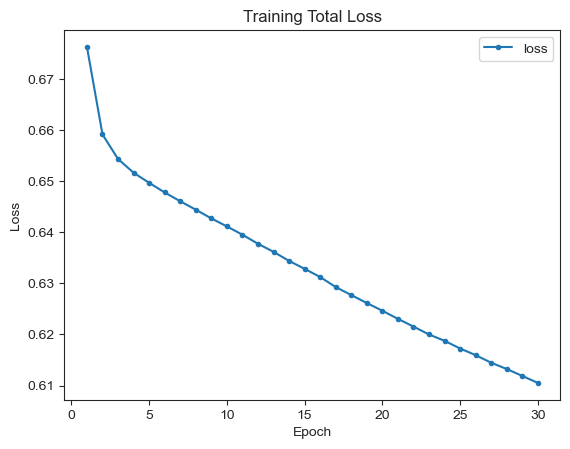

In [271]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("ticks")
plt.plot(range(1, 31), df['loss'], label='loss', marker='.')
plt.legend()
plt.title("Training Total Loss")
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.show()

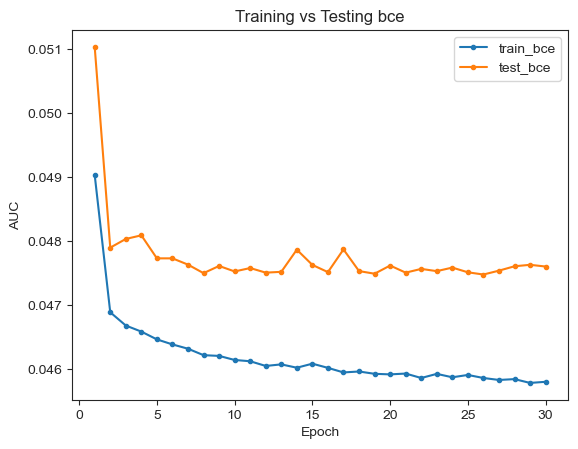

In [272]:
plt.plot(range(1, 31), df['binary_crossentropy'],label='train_bce', marker='.')
plt.plot(range(1, 31), df['val_binary_crossentropy'], label='test_bce', marker='.')
plt.title("Training vs Testing bce")
plt.xlabel('Epoch')
plt.ylabel("AUC")
plt.legend()
plt.show()

## Evaluate

In [122]:
train_eval = {"logloss":[],
              "AUC": []}
test_eval = {"val_logloss":[],
              "val_AUC": []}
for i in range(1, 4):
    model.load_state_dict(torch.load(f'../../checkpoint/PLE_{i}.pth'))
    model.eval()
    pred_train = model.predict(train_model_input, 256)
    for i, target_name in enumerate(target):
        train_eval['logloss'].append(round(log_loss(train[target[i]].values, pred_train[:, i]), 4)) 
        train_eval['AUC'].append(round(roc_auc_score(train[target[i]].values, pred_train[:, i]), 4))
    pred_test = model.predict(test_model_input, 256)
    for i, target_name in enumerate(target):
        test_eval['val_logloss'].append(round(log_loss(test[target[i]].values, pred_test[:, i]), 4)) 
        test_eval['val_AUC'].append(round(roc_auc_score(test[target[i]].values, pred_test[:, i]), 4))

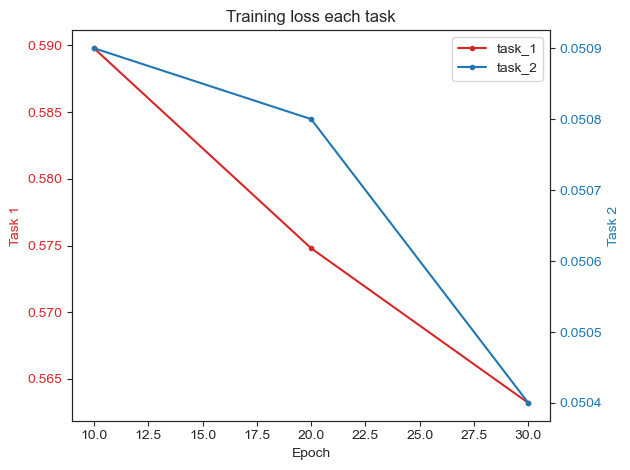

In [273]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(range(10, 31, 10), train_eval['logloss'][0:6:2],label='task_1', marker='.', color='tab:red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel("Task 1", color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2.plot(range(10, 31, 10), train_eval['logloss'][1:6:2], label='task_2', marker='.', color='tab:blue')
ax2.set_ylabel("Task 2", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

handles, labels = [], []
for ax in [ax1, ax2]:
    h, l = ax.get_legend_handles_labels()
    handles += h 
    labels += l
plt.legend(handles, labels, loc='best')
plt.title("Training loss each task")
plt.tight_layout()
plt.show()

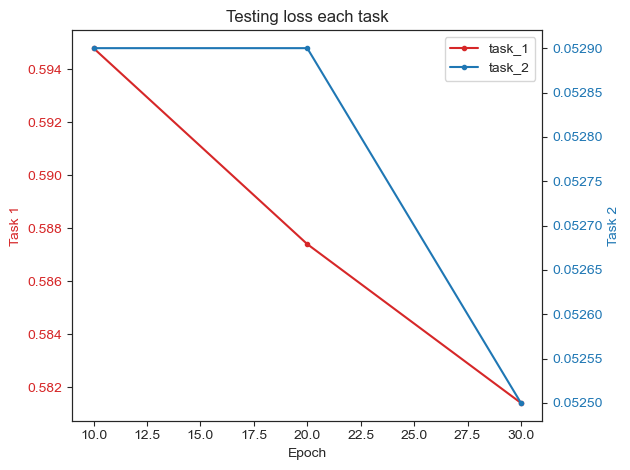

In [275]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(range(10, 31, 10), test_eval['val_logloss'][0:6:2],label='task_1', marker='.', color='tab:red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel("Task 1", color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2.plot(range(10, 31, 10), test_eval['val_logloss'][1:6:2], label='task_2', marker='.', color='tab:blue')
ax2.set_ylabel("Task 2", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

handles, labels = [], []
for ax in [ax1, ax2]:
    h, l = ax.get_legend_handles_labels()
    handles += h 
    labels += l
plt.legend(handles, labels, loc='best')
plt.title("Testing loss each task")
plt.tight_layout()
plt.show()

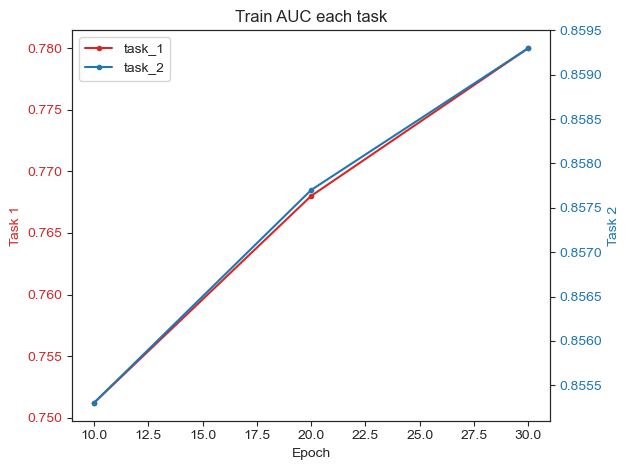

In [292]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(range(10, 31, 10), train_eval['AUC'][0:6:2],label='task_1', marker='.', color='tab:red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel("Task 1", color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2.plot(range(10, 31, 10), train_eval['AUC'][1:6:2], label='task_2', marker='.', color='tab:blue')
ax2.set_ylabel("Task 2", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

handles, labels = [], []
for ax in [ax1, ax2]:
    h, l = ax.get_legend_handles_labels()
    handles += h 
    labels += l
plt.legend(handles, labels, loc='best')
plt.title("Train AUC each task")
plt.tight_layout()
plt.show()

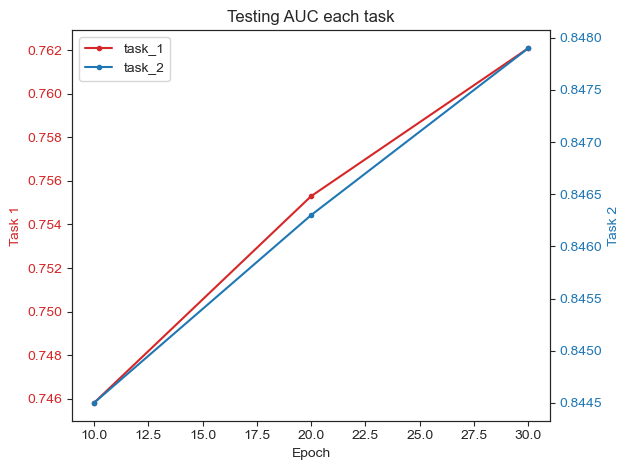

In [276]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(range(10, 31, 10), test_eval['val_AUC'][0:6:2],label='task_1', marker='.', color='tab:red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel("Task 1", color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2.plot(range(10, 31, 10), test_eval['val_AUC'][1:6:2], label='task_2', marker='.', color='tab:blue')
ax2.set_ylabel("Task 2", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

handles, labels = [], []
for ax in [ax1, ax2]:
    h, l = ax.get_legend_handles_labels()
    handles += h 
    labels += l
plt.legend(handles, labels, loc='best')
plt.title("Testing AUC each task")
plt.tight_layout()
plt.show()

In [22]:
pred_ans = model.predict(train_model_input, 256)
for i, target_name in enumerate(target):
    print("%s train LogLoss" % target_name, round(log_loss(train[target[i]].values, pred_ans[:, i]), 4))
    print("%s train AUC" % target_name, round(roc_auc_score(train[target[i]].values, pred_ans[:, i]), 4))

click test LogLoss 0.5632
click test AUC 0.78
conversion test LogLoss 0.0504
conversion test AUC 0.8593


In [23]:
pred_ans = model.predict(test_model_input, 256)
print("")
for i, target_name in enumerate(target):
    print("%s test LogLoss" % target_name, round(log_loss(test[target[i]].values, pred_ans[:, i]), 4))
    print("%s test AUC" % target_name, round(roc_auc_score(test[target[i]].values, pred_ans[:, i]), 4))


click test LogLoss 0.5814
click test AUC 0.7621
conversion test LogLoss 0.0525
conversion test AUC 0.8479


# Test

### example 1

In [32]:
iloc = np.random.randint(len(test))
example = test.iloc[iloc:iloc+3]
example_input = {name: example[name] for name in feature_names}

In [33]:
pred = model.predict(example_input,3)

In [34]:
pd.DataFrame(pred, columns=['click', 'conversion'])

,click,conversion
0,0.808131,0.006829
1,0.472689,0.000653
2,0.240626,0.000452


In [35]:
example[target]

,click,conversion
102899,1,0
114742,0,0
59937,0,0


### example 2

In [50]:
iloc = np.random.randint(len(test))
example = test.iloc[iloc:iloc+3]
example_input = {name: example[name] for name in feature_names}

pred = model.predict(example_input,3)
pd.DataFrame(pred, columns=['click', 'conversion'])

,click,conversion
0,0.777804,0.074289
1,0.738686,0.011803
2,0.859961,0.004652


In [51]:
example[target]

,click,conversion
25307,1,0
156155,1,0
91749,1,0


In [87]:
model.load_state_dict(torch.load(f'../../checkpoint/PLE_1.pth'))

<All keys matched successfully>

### example 3

In [114]:
conversion = test[test['conversion']==1]
iloc = np.random.randint(len(conversion))
example = conversion.iloc[iloc:iloc+3]
example_input = {name: example[name] for name in feature_names}

pred = model.predict(example_input,3)
pd.DataFrame(pred, columns=['click', 'conversion'])

,click,conversion
0,0.868086,0.104059
1,0.619661,0.044387
2,0.199206,0.030148


In [115]:
example[target]

,click,conversion
154120,1,1
1877,1,1
98114,1,1


# Enhacement

In [158]:
new_data_conversion = data[data['conversion']==1]
new_data_not_conversion = data[data['conversion']==0]
new_data_not_conversion = new_data_not_conversion.iloc[np.random.permutation(len(new_data_not_conversion))][:4000]
new_data = pd.concat([new_data_not_conversion, new_data_conversion], axis=0)
new_data = new_data.iloc[np.random.permutation(len(new_data))]

In [160]:
split_boundary = int(new_data.shape[0] * 0.8)
new_train, new_test = new_data[:split_boundary], new_data[split_boundary:]
new_train_model_input = {name: new_train[name] for name in feature_names}
new_test_model_input = {name: new_test[name] for name in feature_names}

In [ ]:
history = model.fit(new_train_model_input, new_train[target].values,validation_split=
                    0.2, batch_size=64, epochs=30, verbose=1)

In [ ]:
df2 = pd.DataFrame(history.history)
df2.to_csv('../../checkpoint/history_2.csv')

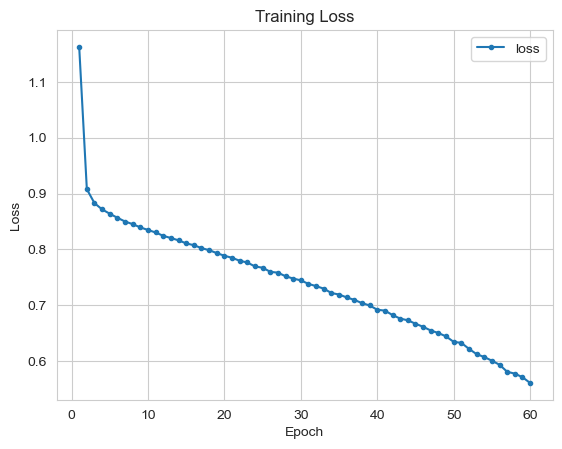

In [192]:
plt.plot(range(1, 61), df2.iloc[30:, 0], label='loss', marker='.')
plt.legend()
plt.title("Training Loss")
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.show()

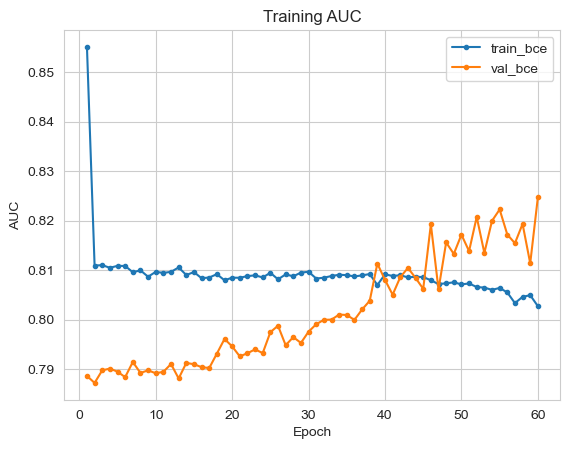

In [193]:
plt.plot(range(1, 61), df2.iloc[30:, 1], label='train_bce', marker='.')
plt.plot(range(1, 61), df2.iloc[30:, 2], label='val_bce', marker='.')
plt.legend()
plt.title("Training AUC")
plt.xlabel('Epoch')
plt.ylabel("AUC")
plt.show()

In [200]:
pred_train = model.predict(train_model_input, 256)
for i, target_name in enumerate(target):
    print("train_{}_loss : {}".format(target_name, round(log_loss(train[target[i]].values, pred_train[:, i]), 4)))
    print("train_{}_AUC : {}".format(target_name,round(roc_auc_score(train[target[i]].values, pred_train[:, i]), 4)))
pred_test = model.predict(test_model_input, 256)
for i, target_name in enumerate(target):
    print("test_{}_loss : {}".format(target_name,round(log_loss(test[target[i]].values, pred_test[:, i]), 4)) )
    print("test_{}_AUC : {}".format(target_name,round(roc_auc_score(test[target[i]].values, pred_test[:, i]), 4)))

train_click_loss : 0.9709
train_click_AUC : 0.7222
train_conversion_loss : 0.4303
train_conversion_AUC : 0.8737
test_click_loss : 1.0186
test_click_AUC : 0.7064
test_conversion_loss : 0.4274
test_conversion_AUC : 0.8659


### example 4

In [289]:
iloc = np.random.randint(len(conversion))
example = new_test.iloc[iloc:iloc+3]
example_input = {name: example[name] for name in feature_names}

pred = (model.predict(example_input,3) >0.5).astype(int)
pd.DataFrame(pred, columns=['click', 'conversion'])

,click,conversion
0,1,1
1,0,0
2,1,1


In [290]:
example[target]

,click,conversion
160120,1,1
79728,0,0
157555,1,1


### example 5

In [287]:
iloc = np.random.randint(len(conversion))
example = new_test.iloc[iloc:iloc+3]
example_input = {name: example[name] for name in feature_names}

pred = (model.predict(example_input,3) >0.5).astype(int)
pd.DataFrame(pred, columns=['click', 'conversion'])

,click,conversion
0,0,0
1,1,1
2,0,0


In [288]:
example[target]

,click,conversion
154117,0,0
22221,1,1
107198,0,0


### example 6

In [285]:
iloc = np.random.randint(len(conversion))
example = new_test.iloc[iloc:iloc+3]
example_input = {name: example[name] for name in feature_names}

pred = (model.predict(example_input,3) >0.5).astype(int)
pd.DataFrame(pred, columns=['click', 'conversion'])

,click,conversion
0,1,1
1,1,1
2,0,0


In [286]:
example[target]

,click,conversion
88039,1,1
137684,1,1
126513,0,0


### example 7

In [281]:
iloc = np.random.randint(len(conversion))
example = new_test.iloc[iloc:iloc+3]
example_input = {name: example[name] for name in feature_names}

pred = (model.predict(example_input,3) >0.5).astype(int)
pd.DataFrame(pred, columns=['click', 'conversion'])

,click,conversion
0,0,0
1,1,1
2,1,0


In [282]:
example[target]

,click,conversion
90789,0,0
96770,1,1
85909,1,0
